In [3]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import matplotlib.pyplot as plt
from data import *
from IDC_parameters import *
'''
IW_simulation=IW_simulation/100
BW_simulation=BW_simulation/100
load_96points_quantiles=load_96points_quantiles/100
'''
T=24
TD=4

IW_simulation=1e3*np.array([0.75,1.2,1.6,2.2,2.75,3.2,3.4,3.5,3.45,3.2,3.0,2.9,
                                        2.9,3.0,3.2,3.4,3.5,3.4,3.2,2.8,2.2,1.6,1.1,0.7])/1.5
BW_simulation=1e2*np.array([1.3,2,3.7,4,5.7,5.7,6,6.8,6.8,6,5.7,5.7,5.7,5.7,6,6.8,6.8,6.8,6,5.7,4,3.7,2])*2
pq_ratio=np.array([0.1,0.1,0.1,0.2,0.25,0.3,
                   0.3,0.3,0.4,0.4,0.5,0.5,
                   0.6,0.6,0.8,0.6,0.4,0.4,
                   0.36,0.3,0.25,0.2,0.15,0.1])*2
#电力潮流相关约束，2，3，6节点的发电机改为风电
model2=gp.Model('24point OPF')
#声明各个决策变量，每一个T维的变量表示该节点/电机/线路T个小时中每小时的功率
gen_Ps,gen_Qs,bus_square_voltages,branch_P,branch_Q,branch_square_currents=[],[],[],[],[],[]
for i in range(3):
    tmp_p=model2.addVars(T,lb=0,ub=4000,vtype=GRB.CONTINUOUS,name=f'generator_p_{i+1}')
    tmp_q=model2.addVars(T,lb=0,ub=4000,vtype=GRB.CONTINUOUS,name=f'generator_q_{i+1}')
    gen_Ps.append(tmp_p)
    gen_Qs.append(tmp_q)
#
for i in range(3):
    tmp_p=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'WT_p_{i+1}')
    #tmp_q=model2.addVars(T,lb=0,ub=2000,vtype=GRB.CONTINUOUS,name=f'generator_q_{i+1}')
    WT_Ps.append(tmp_p)
    
for i in range(32):
    tmp_bus_square_voltage=model2.addVars(T,lb=Vmin*Vmin,ub=Vmax*Vmax,vtype=GRB.CONTINUOUS,name=f'bus_square_voltage_{i+1}')
    tmp_branch_p=model2.addVars(T,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_P_{i+1}')
    tmp_branch_q=model2.addVars(T,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_Q_{i+1}')
    tmp_branch_square_current=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_square_{i+1}')
    bus_square_voltages.append(tmp_bus_square_voltage)
    branch_P.append(tmp_branch_p)
    branch_Q.append(tmp_branch_q)
    branch_square_currents.append(tmp_branch_square_current) 
    
A_BW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_BW_t')
A_IW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_IW_t')
A_R_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_R_t')
L_BW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_BW_t')
L_IW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_IW_t')
#P_res_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_res_t')
P_data_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_data_t')
P_cooling_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='p_cooling_t')
T_cooling=model2.addVars(T,lb=10,ub=40,vtype=GRB.CONTINUOUS,name='T_cooling')

#数据中心相关约束
#数据处理相关约束
for i in range(T):
    model2.addConstr(P_data_t[i]==(P_idle+0.75*P_peak)*(A_BW_t[i]+A_IW_t[i])+P_idle*A_R_t[i])
                     #+(L_BW_t[i]+L_IW_t[i])*(P_peak-P_idle)/L_rate)
    model2.addConstr(A_IW_t[i]>=L_IW_t[i]/(L_rate-1/C_DT))
    model2.addConstr(L_IW_t[i]>=IW_simulation[i])
    model2.addConstr(L_rate*A_BW_t[i]>=L_BW_t[i])
    #对于可延迟负荷，当前处理的功率（累计值）小于当前的负荷值
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i))<=gp.quicksum(BW_simulation[j] for j in range(0,i)))
    #在截止时间之前处理完毕
for i in range(T-TD):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i+TD))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T-TD,T):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,T))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T):
    model2.addConstr(A_R_t[i]>=redundant_ratio*A_max)
    model2.addConstr(A_IW_t[i]+A_BW_t[i]+A_R_t[i]<=A_max)
#数据中心制冷相关约束
#初始状态T_cooling=T_env=22℃
#model2.addConstr(P_cooling_t[0]<=1000)
model2.addConstr(T_cooling[0]==cooling_coef*22+(1-cooling_coef)*T_env[0]+cooling_g*(1-cooling_coef)*P_data_t[0]
                 -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[0])
model2.addConstr(T_cooling[0]>=18)
model2.addConstr(T_cooling[0]<=26)
for i in range(1,T):
    #model2.addConstr(P_cooling_t[i]<=1000)
    model2.addConstr(T_cooling[i]==cooling_coef*T_cooling[i-1]+(1-cooling_coef)*T_env[i]+cooling_g*(1-cooling_coef)*P_data_t[i]
                     -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[i])
    model2.addConstr(T_cooling[i]>=18)
    model2.addConstr(T_cooling[i]<=26)    
#风电出力约束

        
#主线
#节点2
#后一个节点电压=前一个节点电压和功率、电流的关系
#统一循环变量i表示时间点，循环变量j表示节点
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[0][i]==1e6*Vm*Vm-2*1e3*(branch_r[0]*branch_P[0][i]+branch_x[0]*branch_Q[0][i])
                    +(branch_r[0]*branch_r[0]+branch_x[0]*branch_x[0])*branch_square_currents[0][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[0][i]>=bus_Pd[0]*pq_ratio[i]+branch_P[1][i]+branch_P[17][i]+branch_square_currents[0][i]*branch_r[0]/1e3
                     -WT_Ps[0][i])
                     #-WT_96points_quantiles[i])
    model2.addConstr(branch_Q[0][i]-branch_square_currents[0][i]*branch_x[0]/1e3==bus_Qd[0]*pq_ratio[i]+branch_Q[1][i]+branch_Q[17][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[0][i]**2+4*branch_Q[0][i]**2+(branch_square_currents[0][i]-Vm*Vm)**2<=
                    (branch_square_currents[0][i]+Vm*Vm)**2)
#节点3
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[1][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[1]*branch_P[1][i]+branch_x[1]*branch_Q[1][i])
                    +(branch_r[1]*branch_r[1]+branch_x[1]*branch_x[1])*branch_square_currents[1][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[1][i]>=bus_Pd[1]*pq_ratio[i]+branch_P[2][i]+branch_P[21][i]+branch_square_currents[1][i]*branch_r[1]/1e3
                     -WT_Ps[1][i])
                     #-WT_96points_quantiles[i])
    model2.addConstr(branch_Q[1][i]-branch_square_currents[1][i]*branch_x[1]/1e3==bus_Qd[1]*pq_ratio[i]+branch_Q[2][i]+branch_Q[21][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[1][i]**2+4*branch_Q[1][i]**2+(branch_square_currents[1][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[1][i]+bus_square_voltages[0][i])**2)
#节点4
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[2][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[2]*branch_P[2][i]+branch_x[2]*branch_Q[2][i])
                    +(branch_r[2]*branch_r[2]+branch_x[2]*branch_x[2])*branch_square_currents[2][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[2][i]-branch_square_currents[2][i]*branch_r[2]/1e3==bus_Pd[2]*pq_ratio[i]+branch_P[3][i])
    model2.addConstr(branch_Q[2][i]-branch_square_currents[2][i]*branch_x[2]/1e3==bus_Qd[2]*pq_ratio[i]+branch_Q[3][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[2][i]**2+4*branch_Q[2][i]**2+(branch_square_currents[2][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[2][i]+bus_square_voltages[1][i])**2)
#节点5
#节点5挂数据中心
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[3][i]==1e6*bus_square_voltages[2][i]-2*1e3*(branch_r[3]*branch_P[3][i]+branch_x[3]*branch_Q[3][i])
                    +(branch_r[3]*branch_r[3]+branch_x[3]*branch_x[3])*branch_square_currents[3][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[3][i]-branch_square_currents[3][i]*branch_r[3]/1e3==bus_Pd[3]*pq_ratio[i]+branch_P[4][i]+P_data_t[i]+P_cooling_t[i])
    model2.addConstr(branch_Q[3][i]-branch_square_currents[3][i]*branch_x[3]/1e3==bus_Qd[3]*pq_ratio[i]+branch_Q[4][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[3][i]**2+4*branch_Q[3][i]**2+(branch_square_currents[3][i]-bus_square_voltages[2][i])**2<=
                    (branch_square_currents[3][i]+bus_square_voltages[2][i])**2)
#节点6
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[4][i]==1e6*bus_square_voltages[3][i]-2*1e3*(branch_r[4]*branch_P[4][i]+branch_x[4]*branch_Q[4][i])
                    +(branch_r[4]*branch_r[4]+branch_x[4]*branch_x[4])*branch_square_currents[4][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[4][i]>=bus_Pd[4]*pq_ratio[i]+branch_P[5][i]+branch_P[24][i]+branch_square_currents[4][i]*branch_r[4]/1e3
                     -WT_Ps[2][i])       
                    #-WT_96points_quantiles[i])
    model2.addConstr(branch_Q[4][i]-branch_square_currents[4][i]*branch_x[4]/1e3==bus_Qd[4]*pq_ratio[i]+branch_Q[5][i]+branch_Q[24][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[4][i]**2+4*branch_Q[4][i]**2+(branch_square_currents[4][i]-bus_square_voltages[3][i])**2<=
                    (branch_square_currents[4][i]+bus_square_voltages[3][i])**2)
#节点7到17
#再次强调：循环变量i表示时间点，循环变量j表示节点和线路的编号
for j in range(7,18):
    for i in range(T):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][i]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点18
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[16][i]==1e6*bus_square_voltages[15][i]-2*1e3*(branch_r[16]*branch_P[16][i]+branch_x[16]*branch_Q[16][i])
                    +(branch_r[16]*branch_r[16]+branch_x[16]*branch_x[16])*branch_square_currents[16][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[16][i]-branch_square_currents[16][i]*branch_r[16]/1e3==bus_Pd[16]*pq_ratio[i])
    model2.addConstr(branch_Q[16][i]-branch_square_currents[16][i]*branch_x[16]/1e3==bus_Qd[16]*pq_ratio[i])
    #线上电流关系
    model2.addQConstr(4*branch_P[16][i]**2+4*branch_Q[16][i]**2+(branch_square_currents[16][i]-bus_square_voltages[15][i])**2<=
                    (branch_square_currents[16][i]+bus_square_voltages[15][i])**2)
    
#支路1：节点19到节点22
#节点19
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[17][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[17]*branch_P[17][i]+branch_x[17]*branch_Q[17][i])
                    +(branch_r[17]*branch_r[17]+branch_x[17]*branch_x[17])*branch_square_currents[17][i])
    model2.addConstr(branch_P[17][i]-branch_square_currents[17][i]*branch_r[17]/1e3==bus_Pd[17]*pq_ratio[i]+branch_P[18][i])
    model2.addConstr(branch_Q[17][i]-branch_square_currents[17][i]*branch_x[17]/1e3==bus_Qd[17]*pq_ratio[i]+branch_Q[18][i])
    model2.addQConstr(4*branch_P[17][i]**2+4*branch_Q[17][i]**2+(branch_square_currents[17][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[17][i]+bus_square_voltages[0][i])**2)
#节点20
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[18][i]==1e6*bus_square_voltages[17][i]-2*1e3*(branch_r[18]*branch_P[18][i]+branch_x[18]*branch_Q[18][i])
                    +(branch_r[18]*branch_r[18]+branch_x[18]*branch_x[18])*branch_square_currents[18][i])
    model2.addConstr(branch_P[18][i]-branch_square_currents[18][i]*branch_r[18]/1e3==bus_Pd[18]*pq_ratio[i]+branch_P[19][i])
    model2.addConstr(branch_Q[18][i]-branch_square_currents[18][i]*branch_x[18]/1e3==bus_Qd[18]*pq_ratio[i]+branch_Q[19][i])
    model2.addQConstr(4*branch_P[18][i]**2+4*branch_Q[18][i]**2+(branch_square_currents[18][i]-bus_square_voltages[17][i])**2<=
                    (branch_square_currents[18][i]+bus_square_voltages[17][i])**2)
#节点21
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[19][i]==1e6*bus_square_voltages[18][i]-2*1e3*(branch_r[19]*branch_P[19][i]+branch_x[19]*branch_Q[19][i])
                    +(branch_r[19]*branch_r[19]+branch_x[19]*branch_x[19])*branch_square_currents[19][i])
    model2.addConstr(branch_P[19][i]-branch_square_currents[19][i]*branch_r[19]/1e3==bus_Pd[19]*pq_ratio[i]+branch_P[20][i])
    model2.addConstr(branch_Q[19][i]-branch_square_currents[19][i]*branch_x[19]/1e3==bus_Qd[19]*pq_ratio[i]+branch_Q[20][i])
    model2.addQConstr(4*branch_P[19][i]**2+4*branch_Q[19][i]**2+(branch_square_currents[19][i]-bus_square_voltages[18][i])**2<=
                    (branch_square_currents[19][i]+bus_square_voltages[18][i])**2)
#节点22
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[20][i]==1e6*bus_square_voltages[19][i]-2*1e3*(branch_r[20]*branch_P[20][i]+branch_x[20]*branch_Q[20][i])
                    +(branch_r[20]*branch_r[20]+branch_x[20]*branch_x[20])*branch_square_currents[20][i])
    model2.addConstr(branch_P[20][i]-branch_square_currents[20][i]*branch_r[20]/1e3==bus_Pd[20]*pq_ratio[i])
    model2.addConstr(branch_Q[20][i]-branch_square_currents[20][i]*branch_x[20]/1e3==bus_Qd[20]*pq_ratio[i])
    model2.addQConstr(4*branch_P[20][i]**2+4*branch_Q[20][i]**2+(branch_square_currents[20][i]-bus_square_voltages[19][i])**2<=
                    (branch_square_currents[20][i]+bus_square_voltages[19][i])**2)

#支路2：节点23到节点25
#节点23
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[21][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[21]*branch_P[21][i]+branch_x[21]*branch_Q[21][i])
                    +(branch_r[21]*branch_r[21]+branch_x[21]*branch_x[21])*branch_square_currents[21][i])
    model2.addConstr(branch_P[21][i]-branch_square_currents[21][i]*branch_r[21]/1e3==bus_Pd[21]*pq_ratio[i]+branch_P[22][i])
    model2.addConstr(branch_Q[21][i]-branch_square_currents[21][i]*branch_x[21]/1e3==bus_Qd[21]*pq_ratio[i]+branch_Q[22][i])
    model2.addQConstr(4*branch_P[21][i]**2+4*branch_Q[21][i]**2+(branch_square_currents[21][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[21][i]+bus_square_voltages[1][i])**2)
#节点24
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[22][i]==1e6*bus_square_voltages[21][i]-2*1e3*(branch_r[22]*branch_P[22][i]+branch_x[22]*branch_Q[22][i])
                    +(branch_r[22]*branch_r[22]+branch_x[22]*branch_x[22])*branch_square_currents[22][i])
    model2.addConstr(branch_P[22][i]-branch_square_currents[22][i]*branch_r[22]/1e3==bus_Pd[22]*pq_ratio[i]+branch_P[23][i])
    model2.addConstr(branch_Q[22][i]-branch_square_currents[22][i]*branch_x[22]/1e3==bus_Qd[22]*pq_ratio[i]+branch_Q[23][i])
    model2.addQConstr(4*branch_P[22][i]**2+4*branch_Q[22][i]**2+(branch_square_currents[22][i]-bus_square_voltages[21][i])**2<=
                    (branch_square_currents[22][i]+bus_square_voltages[21][i])**2)
#节点25
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[23][i]==1e6*bus_square_voltages[22][i]-2*1e3*(branch_r[23]*branch_P[23][i]+branch_x[23]*branch_Q[23][i])
                    +(branch_r[23]*branch_r[23]+branch_x[23]*branch_x[23])*branch_square_currents[23][i])
    model2.addConstr(branch_P[23][i]-branch_square_currents[23][i]*branch_r[23]/1e3==bus_Pd[23]*pq_ratio[i])
    model2.addConstr(branch_Q[23][i]-branch_square_currents[23][i]*branch_x[23]/1e3==bus_Qd[23]*pq_ratio[i])
    model2.addQConstr(4*branch_P[23][i]**2+4*branch_Q[23][i]**2+(branch_square_currents[23][i]-bus_square_voltages[22][i])**2<=
                    (branch_square_currents[23][i]+bus_square_voltages[22][i])**2)

#支路3：节点26到节点33
#节点26
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[24][i]==1e6*bus_square_voltages[4][i]-2*1e3*(branch_r[24]*branch_P[24][i]+branch_x[24]*branch_Q[24][i])
                    +(branch_r[24]*branch_r[24]+branch_x[24]*branch_x[24])*branch_square_currents[24][i])
    model2.addConstr(branch_P[24][i]-branch_square_currents[24][i]*branch_r[24]/1e3==bus_Pd[24]*pq_ratio[i]+branch_P[25][i])
    model2.addConstr(branch_Q[24][i]-branch_square_currents[24][i]*branch_x[24]/1e3==bus_Qd[24]*pq_ratio[i]+branch_Q[25][i])
    model2.addQConstr(4*branch_P[24][i]**2+4*branch_Q[24][i]**2+(branch_square_currents[24][i]-bus_square_voltages[4][i])**2<=
                    (branch_square_currents[24][i]+bus_square_voltages[4][i])**2)
#节点27到节点32
for j in range(27,33):
    for i in range(T):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][2]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点33
for i in range(T):
    model2.addConstr(1e6*bus_square_voltages[31][i]==1e6*bus_square_voltages[30][i]-2*1e3*(branch_r[31]*branch_P[31][i]+branch_x[31]*branch_Q[31][i])
                    +(branch_r[31]*branch_r[31]+branch_x[31]*branch_x[31])*branch_square_currents[31][i])
    model2.addConstr(branch_P[31][i]-branch_square_currents[31][i]*branch_r[31]/1e3==bus_Pd[31]*pq_ratio[i])
    model2.addConstr(branch_Q[31][i]-branch_square_currents[31][i]*branch_x[31]/1e3==bus_Qd[31]*pq_ratio[i])
    model2.addQConstr(4*branch_P[31][i]**2+4*branch_Q[31][i]**2+(branch_square_currents[31][i]-bus_square_voltages[30][i])**2<=
                    (branch_square_currents[31][i]+bus_square_voltages[30][i])**2)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-05


NameError: name 'WT_Ps' is not defined

Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 11605 rows, 13632 columns and 44832 nonzeros
Model fingerprint: 0x0c54e02c
Model has 3072 quadratic constraints
Variable types: 13344 continuous, 288 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+06]
  QMatrix range    [4e+00, 4e+00]
  QLMatrix range   [6e+02, 6e+02]
  Objective range  [4e-01, 6e-01]
  Bounds range     [1e+01, 4e+04]
  RHS range        [6e-01, 2e+08]
Presolve removed 1523 rows and 861 columns
Presolve time: 0.35s
Presolved: 10082 rows, 12771 columns, 39854 nonzeros
Presolved model has 3072 quadratic constraint(s)
Variable types: 12483 continuous, 288 integer (0 binary)

Root relaxation: objective 5.061885e+04, 4931 iterations, 0.05 seconds (0.06 work units)

    Nodes  

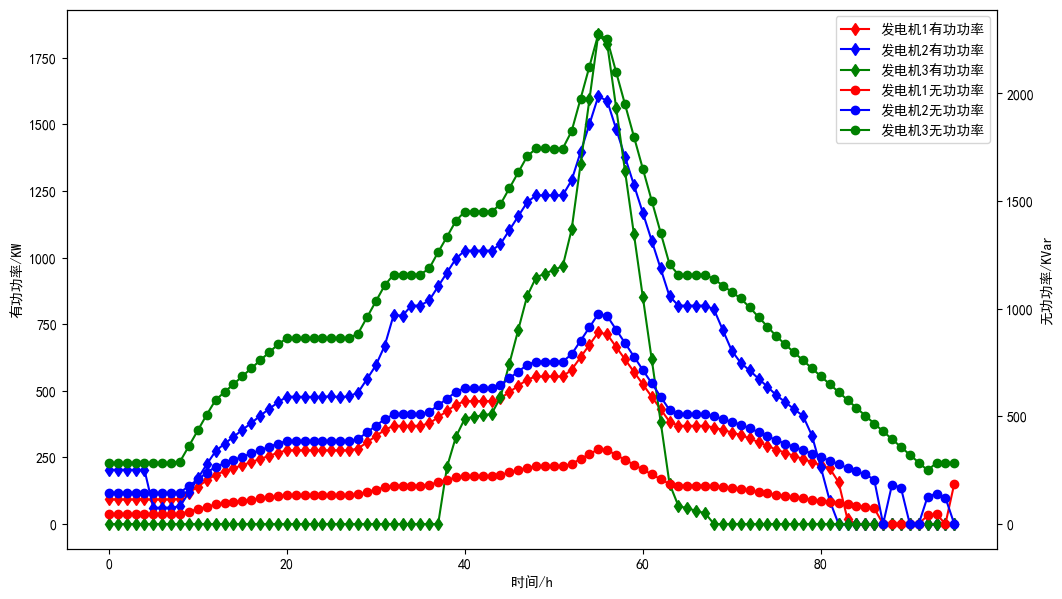

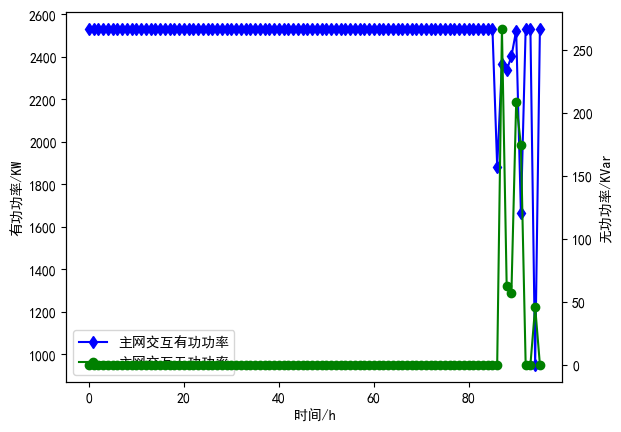

In [26]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import matplotlib.pyplot as plt
from data import *
from IDC_parameters import *
#任务2 以最优潮流问题为基础的96点优化调度
#负荷比例：24个小时中，每个时间点每个节点的有功/无功负荷相对基准值（即开头表中值）的比例
#负荷根据实际需要任意修改即可，这里只做实验用
def interpolate_data(data):
    # Ensure input data length is 24
    if len(data) != 24:
        raise ValueError("Input array must have exactly 24 elements.")
    
    # Original x coordinates, from 0 to 23
    x_original = np.arange(24)
    
    # New x coordinates, from 0 to 95, total 96 points
    x_new = np.linspace(0, 24, 96)
    
    # Use linear interpolation function
    f = interp1d(x_original, data, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Interpolate and get new data
    interpolated_data = f(x_new[:-3])  # Handle the first 93 points
    
    # Special handling for the last three points, using the first and last point of the original array for interpolation
    last_point = data[-1]
    first_point = data[0]
    extended_x = np.array([24, 25, 26])
    extended_y = np.array([last_point, first_point, first_point])
    
    # Extended interpolation function
    f_extended = interp1d(extended_x, extended_y, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Get the data for the last three points
    last_three_points = f_extended(x_new[-3:])
    
    # Combine the two parts of data
    final_data = np.concatenate((interpolated_data, last_three_points))
    
    return final_data

predicted_BWs=5e2*np.array([1.3,2,3.7,4,5.4,5.7,6,6.4,6.8,6,5.8,5.6,5.4,5.7,6,6.4,6.8,6.4,6,5.6,4,3.7,2,1.6])
predicted_IWs=5e2*np.array([0.75,1.2,1.6,2.2,2.75,3.2,3.4,3.5,3.45,3.2,3.0,2.9,
                                        2.9,3.0,3.2,3.4,3.5,3.4,3.2,2.8,2.2,1.6,1.1,0.7])
pq_ratio=np.array([0.1,0.1,0.1,0.2,0.25,0.3,
                   0.3,0.3,0.4,0.4,0.5,0.5,
                   0.6,0.6,0.8,0.6,0.4,0.4,
                   0.36,0.3,0.25,0.2,0.15,0.1])*2
electricity_price=np.array([29,26,23,23,24,25,31,30,32,33,34,35,37,41,44,52,62,50,40,36,38,34,32,30])
IW_simulation=interpolate_data(predicted_IWs)
BW_simulation=interpolate_data(predicted_BWs)
pq_ratio=interpolate_data(pq_ratio)
electricity_price=interpolate_data(electricity_price)/100
model2=gp.Model('96 point OPF')
#声明各个决策变量，每一个96维的变量表示该节点/电机/线路96个小时中每小时的功率
gen_Ps,gen_Qs,bus_square_voltages,branch_P,branch_Q,branch_square_currents=[],[],[],[],[],[]
for i in range(3):
    tmp_p=model2.addVars(96,lb=0,ub=4000,vtype=GRB.CONTINUOUS,name=f'generator_p_{i+1}')
    tmp_q=model2.addVars(96,lb=0,ub=4000,vtype=GRB.CONTINUOUS,name=f'generator_q_{i+1}')
    gen_Ps.append(tmp_p)
    gen_Qs.append(tmp_q)
for i in range(32):
    tmp_bus_square_voltage=model2.addVars(96,lb=Vmin*Vmin,ub=Vmax*Vmax,vtype=GRB.CONTINUOUS,name=f'bus_square_voltage_{i+1}')
    tmp_branch_p=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_P_{i+1}')
    tmp_branch_q=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_Q_{i+1}')
    tmp_branch_square_current=model2.addVars(96,lb=0,ub=4e4,vtype=GRB.CONTINUOUS,name=f'branch_square_{i+1}')
    bus_square_voltages.append(tmp_bus_square_voltage)
    branch_P.append(tmp_branch_p)
    branch_Q.append(tmp_branch_q)
    branch_square_currents.append(tmp_branch_square_current) 
    
#发电机爬坡功率约束,设发电机爬坡能力为400kW/h
for i in range(3):
    for j in range(1,96):
        model2.addConstr(gen_Ps[i][j]-gen_Ps[i][j-1]<=400)
        model2.addConstr(gen_Ps[i][j]-gen_Ps[i][j-1]>=-400)
        model2.addConstr(gen_Qs[i][j]-gen_Qs[i][j-1]<=400)
        model2.addConstr(gen_Qs[i][j]-gen_Qs[i][j-1]>=-400)

T=96
TD=16

A_BW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_BW_t')
A_IW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_IW_t')
A_R_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_R_t')
L_BW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_BW_t')
L_IW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_IW_t')
#P_res_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_res_t')
P_data_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_data_t')
P_cooling_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='p_cooling_t')
T_cooling=model2.addVars(T,lb=10,ub=40,vtype=GRB.CONTINUOUS,name='T_cooling')

#数据中心相关约束
#数据处理相关约束
for i in range(T):
    model2.addConstr(P_data_t[i]==(P_idle+0.75*P_peak)*(A_BW_t[i]+A_IW_t[i])+P_idle*A_R_t[i]+(L_BW_t[i]+L_IW_t[i])*(P_peak-P_idle)/L_rate)
    model2.addConstr(A_IW_t[i]>=L_IW_t[i]/(L_rate-1/C_DT))
    model2.addConstr(L_IW_t[i]>=IW_simulation[i])
    model2.addConstr(L_rate*A_BW_t[i]>=L_BW_t[i])
    #对于可延迟负荷，当前处理的功率（累计值）小于当前的负荷值
   # model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i))<=gp.quicksum(BW_simulation[j] for j in range(0,i)))
    #在截止时间之前处理完毕
for i in range(T-TD):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i+TD))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T-TD,T):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,T))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T):
    model2.addConstr(A_R_t[i]>=redundant_ratio*A_max)
    model2.addConstr(A_IW_t[i]+A_BW_t[i]+A_R_t[i]<=A_max)
#数据中心制冷相关约束
#初始状态T_cooling=T_env=22℃
model2.addConstr(P_cooling_t[0]<=1000)
model2.addConstr(T_cooling[0]==cooling_coef*22+(1-cooling_coef)*T_env[0]+cooling_g*(1-cooling_coef)*P_data_t[0]
                 -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[0])
model2.addConstr(T_cooling[0]>=20)
model2.addConstr(T_cooling[0]<=24)
for i in range(1,96):
    model2.addConstr(P_cooling_t[i]<=1000)
    model2.addConstr(T_cooling[i]==cooling_coef*T_cooling[i-1]+(1-cooling_coef)*T_env[i]+cooling_g*(1-cooling_coef)*P_data_t[i]
                     -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[i])
    model2.addConstr(T_cooling[i]>=20)
    model2.addConstr(T_cooling[i]<=24)      
model2.addConstr(T_cooling[95]==22)

for i in range(96):
    model2.addConstr(branch_P[0][i]<=4000)
    model2.addConstr(branch_Q[0][i]<=4000)
#主线
#节点2
#后一个节点电压=前一个节点电压和功率、电流的关系
#后面统一循环变量i表示时间点，循环变量j表示节点
#发电机的懒得改了
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[0][i]==1e6*Vm*Vm-2*1e3*(branch_r[0]*branch_P[0][i]+branch_x[0]*branch_Q[0][i])
                    +(branch_r[0]*branch_r[0]+branch_x[0]*branch_x[0])*branch_square_currents[0][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[0][i]+gen_Ps[0][i]-branch_square_currents[0][i]*branch_r[0]/1e3==bus_Pd[0]*pq_ratio[i]+branch_P[1][i]+branch_P[17][i])
    model2.addConstr(branch_Q[0][i]+gen_Qs[0][i]-branch_square_currents[0][i]*branch_x[0]/1e3==bus_Qd[0]*pq_ratio[i]+branch_Q[1][i]+branch_Q[17][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[0][i]**2+4*branch_Q[0][i]**2+(branch_square_currents[0][i]-Vm*Vm)**2<=
                    (branch_square_currents[0][i]+Vm*Vm)**2)
#节点3
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[1][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[1]*branch_P[1][i]+branch_x[1]*branch_Q[1][i])
                    +(branch_r[1]*branch_r[1]+branch_x[1]*branch_x[1])*branch_square_currents[1][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[1][i]+gen_Ps[1][i]-branch_square_currents[1][i]*branch_r[1]/1e3==bus_Pd[1]*pq_ratio[i]+branch_P[2][i]+branch_P[21][i])
    model2.addConstr(branch_Q[1][i]+gen_Qs[1][i]-branch_square_currents[1][i]*branch_x[1]/1e3==bus_Qd[1]*pq_ratio[i]+branch_Q[2][i]+branch_Q[21][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[1][i]**2+4*branch_Q[1][i]**2+(branch_square_currents[1][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[1][i]+bus_square_voltages[0][i])**2)
#节点4
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[2][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[2]*branch_P[2][i]+branch_x[2]*branch_Q[2][i])
                    +(branch_r[2]*branch_r[2]+branch_x[2]*branch_x[2])*branch_square_currents[2][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[2][i]-branch_square_currents[2][i]*branch_r[2]/1e3==bus_Pd[2]*pq_ratio[i]+branch_P[3][i])
    model2.addConstr(branch_Q[2][i]-branch_square_currents[2][i]*branch_x[2]/1e3==bus_Qd[2]*pq_ratio[i]+branch_Q[3][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[2][i]**2+4*branch_Q[2][i]**2+(branch_square_currents[2][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[2][i]+bus_square_voltages[1][i])**2)
#节点5
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[3][i]==1e6*bus_square_voltages[2][i]-2*1e3*(branch_r[3]*branch_P[3][i]+branch_x[3]*branch_Q[3][i])
                    +(branch_r[3]*branch_r[3]+branch_x[3]*branch_x[3])*branch_square_currents[3][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[3][i]-branch_square_currents[3][i]*branch_r[3]/1e3==bus_Pd[3]*pq_ratio[i]+branch_P[4][i]+P_data_t[i]+P_cooling_t[i])
    model2.addConstr(branch_Q[3][i]-branch_square_currents[3][i]*branch_x[3]/1e3==bus_Qd[3]*pq_ratio[i]+branch_Q[4][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[3][i]**2+4*branch_Q[3][i]**2+(branch_square_currents[3][i]-bus_square_voltages[2][i])**2<=
                    (branch_square_currents[3][i]+bus_square_voltages[2][i])**2)
#节点6
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[4][i]==1e6*bus_square_voltages[3][i]-2*1e3*(branch_r[4]*branch_P[4][i]+branch_x[4]*branch_Q[4][i])
                    +(branch_r[4]*branch_r[4]+branch_x[4]*branch_x[4])*branch_square_currents[4][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[4][i]+gen_Ps[2][i]-branch_square_currents[4][i]*branch_r[4]/1e3==bus_Pd[4]*pq_ratio[i]+branch_P[5][i]+branch_P[24][i])
    model2.addConstr(branch_Q[4][i]+gen_Qs[2][i]-branch_square_currents[4][i]*branch_x[4]/1e3==bus_Qd[4]*pq_ratio[i]+branch_Q[5][i]+branch_Q[24][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[4][i]**2+4*branch_Q[4][i]**2+(branch_square_currents[4][i]-bus_square_voltages[3][i])**2<=
                    (branch_square_currents[4][i]+bus_square_voltages[3][i])**2)
#节点7到17
#再次强调：循环变量i表示时间点，循环变量j表示节点和线路的编号
for j in range(7,18):
    for i in range(96):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][i]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点18
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[16][i]==1e6*bus_square_voltages[15][i]-2*1e3*(branch_r[16]*branch_P[16][i]+branch_x[16]*branch_Q[16][i])
                    +(branch_r[16]*branch_r[16]+branch_x[16]*branch_x[16])*branch_square_currents[16][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[16][i]-branch_square_currents[16][i]*branch_r[16]/1e3==bus_Pd[16]*pq_ratio[i])
    model2.addConstr(branch_Q[16][i]-branch_square_currents[16][i]*branch_x[16]/1e3==bus_Qd[16]*pq_ratio[i])
    #线上电流关系
    model2.addQConstr(4*branch_P[16][i]**2+4*branch_Q[16][i]**2+(branch_square_currents[16][i]-bus_square_voltages[15][i])**2<=
                    (branch_square_currents[16][i]+bus_square_voltages[15][i])**2)
    
#支路1：节点19到节点22
#节点19
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[17][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[17]*branch_P[17][i]+branch_x[17]*branch_Q[17][i])
                    +(branch_r[17]*branch_r[17]+branch_x[17]*branch_x[17])*branch_square_currents[17][i])
    model2.addConstr(branch_P[17][i]-branch_square_currents[17][i]*branch_r[17]/1e3==bus_Pd[17]*pq_ratio[i]+branch_P[18][i])
    model2.addConstr(branch_Q[17][i]-branch_square_currents[17][i]*branch_x[17]/1e3==bus_Qd[17]*pq_ratio[i]+branch_Q[18][i])
    model2.addQConstr(4*branch_P[17][i]**2+4*branch_Q[17][i]**2+(branch_square_currents[17][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[17][i]+bus_square_voltages[0][i])**2)
#节点20
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[18][i]==1e6*bus_square_voltages[17][i]-2*1e3*(branch_r[18]*branch_P[18][i]+branch_x[18]*branch_Q[18][i])
                    +(branch_r[18]*branch_r[18]+branch_x[18]*branch_x[18])*branch_square_currents[18][i])
    model2.addConstr(branch_P[18][i]-branch_square_currents[18][i]*branch_r[18]/1e3==bus_Pd[18]*pq_ratio[i]+branch_P[19][i])
    model2.addConstr(branch_Q[18][i]-branch_square_currents[18][i]*branch_x[18]/1e3==bus_Qd[18]*pq_ratio[i]+branch_Q[19][i])
    model2.addQConstr(4*branch_P[18][i]**2+4*branch_Q[18][i]**2+(branch_square_currents[18][i]-bus_square_voltages[17][i])**2<=
                    (branch_square_currents[18][i]+bus_square_voltages[17][i])**2)
#节点21
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[19][i]==1e6*bus_square_voltages[18][i]-2*1e3*(branch_r[19]*branch_P[19][i]+branch_x[19]*branch_Q[19][i])
                    +(branch_r[19]*branch_r[19]+branch_x[19]*branch_x[19])*branch_square_currents[19][i])
    model2.addConstr(branch_P[19][i]-branch_square_currents[19][i]*branch_r[19]/1e3==bus_Pd[19]*pq_ratio[i]+branch_P[20][i])
    model2.addConstr(branch_Q[19][i]-branch_square_currents[19][i]*branch_x[19]/1e3==bus_Qd[19]*pq_ratio[i]+branch_Q[20][i])
    model2.addQConstr(4*branch_P[19][i]**2+4*branch_Q[19][i]**2+(branch_square_currents[19][i]-bus_square_voltages[18][i])**2<=
                    (branch_square_currents[19][i]+bus_square_voltages[18][i])**2)
#节点22
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[20][i]==1e6*bus_square_voltages[19][i]-2*1e3*(branch_r[20]*branch_P[20][i]+branch_x[20]*branch_Q[20][i])
                    +(branch_r[20]*branch_r[20]+branch_x[20]*branch_x[20])*branch_square_currents[20][i])
    model2.addConstr(branch_P[20][i]-branch_square_currents[20][i]*branch_r[20]/1e3==bus_Pd[20]*pq_ratio[i])
    model2.addConstr(branch_Q[20][i]-branch_square_currents[20][i]*branch_x[20]/1e3==bus_Qd[20]*pq_ratio[i])
    model2.addQConstr(4*branch_P[20][i]**2+4*branch_Q[20][i]**2+(branch_square_currents[20][i]-bus_square_voltages[19][i])**2<=
                    (branch_square_currents[20][i]+bus_square_voltages[19][i])**2)

#支路2：节点23到节点25
#节点23
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[21][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[21]*branch_P[21][i]+branch_x[21]*branch_Q[21][i])
                    +(branch_r[21]*branch_r[21]+branch_x[21]*branch_x[21])*branch_square_currents[21][i])
    model2.addConstr(branch_P[21][i]-branch_square_currents[21][i]*branch_r[21]/1e3==bus_Pd[21]*pq_ratio[i]+branch_P[22][i])
    model2.addConstr(branch_Q[21][i]-branch_square_currents[21][i]*branch_x[21]/1e3==bus_Qd[21]*pq_ratio[i]+branch_Q[22][i])
    model2.addQConstr(4*branch_P[21][i]**2+4*branch_Q[21][i]**2+(branch_square_currents[21][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[21][i]+bus_square_voltages[1][i])**2)
#节点24
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[22][i]==1e6*bus_square_voltages[21][i]-2*1e3*(branch_r[22]*branch_P[22][i]+branch_x[22]*branch_Q[22][i])
                    +(branch_r[22]*branch_r[22]+branch_x[22]*branch_x[22])*branch_square_currents[22][i])
    model2.addConstr(branch_P[22][i]-branch_square_currents[22][i]*branch_r[22]/1e3==bus_Pd[22]*pq_ratio[i]+branch_P[23][i])
    model2.addConstr(branch_Q[22][i]-branch_square_currents[22][i]*branch_x[22]/1e3==bus_Qd[22]*pq_ratio[i]+branch_Q[23][i])
    model2.addQConstr(4*branch_P[22][i]**2+4*branch_Q[22][i]**2+(branch_square_currents[22][i]-bus_square_voltages[21][i])**2<=
                    (branch_square_currents[22][i]+bus_square_voltages[21][i])**2)
#节点25
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[23][i]==1e6*bus_square_voltages[22][i]-2*1e3*(branch_r[23]*branch_P[23][i]+branch_x[23]*branch_Q[23][i])
                    +(branch_r[23]*branch_r[23]+branch_x[23]*branch_x[23])*branch_square_currents[23][i])
    model2.addConstr(branch_P[23][i]-branch_square_currents[23][i]*branch_r[23]/1e3==bus_Pd[23]*pq_ratio[i])
    model2.addConstr(branch_Q[23][i]-branch_square_currents[23][i]*branch_x[23]/1e3==bus_Qd[23]*pq_ratio[i])
    model2.addQConstr(4*branch_P[23][i]**2+4*branch_Q[23][i]**2+(branch_square_currents[23][i]-bus_square_voltages[22][i])**2<=
                    (branch_square_currents[23][i]+bus_square_voltages[22][i])**2)

#支路3：节点26到节点33
#节点26
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[24][i]==1e6*bus_square_voltages[4][i]-2*1e3*(branch_r[24]*branch_P[24][i]+branch_x[24]*branch_Q[24][i])
                    +(branch_r[24]*branch_r[24]+branch_x[24]*branch_x[24])*branch_square_currents[24][i])
    model2.addConstr(branch_P[24][i]-branch_square_currents[24][i]*branch_r[24]/1e3==bus_Pd[24]*pq_ratio[i]+branch_P[25][i])
    model2.addConstr(branch_Q[24][i]-branch_square_currents[24][i]*branch_x[24]/1e3==bus_Qd[24]*pq_ratio[i]+branch_Q[25][i])
    model2.addQConstr(4*branch_P[24][i]**2+4*branch_Q[24][i]**2+(branch_square_currents[24][i]-bus_square_voltages[4][i])**2<=
                    (branch_square_currents[24][i]+bus_square_voltages[4][i])**2)
#节点27到节点32
for j in range(27,33):
    for i in range(96):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][2]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点33
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[31][i]==1e6*bus_square_voltages[30][i]-2*1e3*(branch_r[31]*branch_P[31][i]+branch_x[31]*branch_Q[31][i])
                    +(branch_r[31]*branch_r[31]+branch_x[31]*branch_x[31])*branch_square_currents[31][i])
    model2.addConstr(branch_P[31][i]-branch_square_currents[31][i]*branch_r[31]/1e3==bus_Pd[31]*pq_ratio[i])
    model2.addConstr(branch_Q[31][i]-branch_square_currents[31][i]*branch_x[31]/1e3==bus_Qd[31]*pq_ratio[i])
    model2.addQConstr(4*branch_P[31][i]**2+4*branch_Q[31][i]**2+(branch_square_currents[31][i]-bus_square_voltages[30][i])**2<=
                    (branch_square_currents[31][i]+bus_square_voltages[30][i])**2)
    

#先优化网损，别的目标函数（如经济性相关）可以自己随便调整
#model2.setObjective(1)
model2.setParam('TimeLimit',600)
model2.setObjective(0.4*(gp.quicksum(gen_Ps[0][i]  for i in range(T)))+0.5*(gp.quicksum(gen_Ps[1][i]  for i in range(T)))
                    +0.6*(gp.quicksum(gen_Ps[2][i] for i in range(T))))
                    #+gp.quicksum(electricity_price[i]*branch_P[0][i] for i in range(T))+gp.quicksum(electricity_price[i]*branch_Q[0][i] for i in range(T)),GRB.MINIMIZE)
#model2.setObjective(gp.quicksum(gp.quicksum(branch_square_currents[j][i]*branch_r[j] for j in range(32)) for i in range(96)))
if model2.Status == GRB.INFEASIBLE:
    # 查找最小不可行子集
    model2.computeIIS()
    
    # 打印不可行子集中的约束
    for constr in model2.getConstrs():
        if constr.IISConstr:
            print(f"Constraint {constr.ConstrName} is in the IIS.")
model2.optimize()

gen_active_power_1,gen_active_power_2,gen_active_power_3,gen_reactive_power_1,gen_reactive_power_2,gen_reactive_power_3=[],[],[],[],[],[]
for i in range(96):
    gen_active_power_1.append(gen_Ps[0][i].X)
    gen_active_power_2.append(gen_Ps[1][i].X)
    gen_active_power_3.append(gen_Ps[2][i].X)
    gen_reactive_power_1.append(gen_Qs[0][i].X)
    gen_reactive_power_2.append(gen_Qs[1][i].X)
    gen_reactive_power_3.append(gen_Qs[2][i].X)
utility_grid_active_power_exchange,utility_grid_reactive_power_exchange=[],[]
for i in range(96):
    utility_grid_active_power_exchange.append(branch_P[0][i].X)
    utility_grid_reactive_power_exchange.append(branch_Q[0][i].X)

plt.rcParams['font.sans-serif'] = ['SimHei'] 
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

#绘制三个发电机的出力曲线
fig1, ax1 = plt.subplots(figsize=(12,7))
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(gen_active_power_1,marker='d',color='r',label='发电机1有功功率')
ax2.plot(gen_reactive_power_1,marker='o',color='r',label='发电机1无功功率')
ax1.plot(gen_active_power_2,marker='d',color='b',label='发电机2有功功率')
ax2.plot(gen_reactive_power_2,marker='o',color='b',label='发电机2无功功率')
ax1.plot(gen_active_power_3,marker='d',color='g',label='发电机3有功功率')
ax2.plot(gen_reactive_power_3,marker='o',color='g',label='发电机3无功功率')

lines1,labels1=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='best')
#plt.show()

#绘制主网交互功率曲线
fig1, ax1 = plt.subplots()
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(utility_grid_active_power_exchange,marker='d',color='b',label='主网交互有功功率')
ax2.plot(utility_grid_reactive_power_exchange,marker='o',color='g',label='主网交互无功功率')

lines1,labels1=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='best')
#plt.show()





In [27]:
'''
gen_Ps_val=[gen_Ps[i].X for i in range(3)]
gen_Qs_val=[gen_Qs[i].X for i in range(3)]
branch_P_val=[branch_P[i].X for i in range(32)]
branch_Q_val=[branch_Q[i].X for i in range(32)]
bus_square_voltages_val=[bus_square_voltages[i].X for i in range(32)]
branch_square_currents_val=[branch_square_currents[i].X for i in range(32)]
'''
gen_Ps_val,gen_Qs_val,bus_square_voltages_val,branch_P_val,branch_Q_val,branch_square_currents_val=[],[],[],[],[],[]
for i in range(3):
    tmp_genP_val=np.array([v.X for v in gen_Ps[i].values()])
    tmp_genQ_val=np.array([v.X for v in gen_Qs[i].values()])
    gen_Ps_val.append(tmp_genP_val)
    gen_Qs_val.append(tmp_genQ_val)
for i in range(32):
    tmp_bus_square_voltage_val=np.array([v.X for v in bus_square_voltages[i].values()])
    tmp_branch_p_val=np.array([v.X for v in branch_P[i].values()])
    tmp_branch_q_val=np.array([v.X for v in branch_Q[i].values()])
    tmp_branch_square_current_val=np.array([v.X for v in branch_square_currents[i].values()])
    bus_square_voltages_val.append(tmp_bus_square_voltage_val)
    branch_P_val.append(tmp_branch_p_val)
    branch_Q_val.append(tmp_branch_q_val)
    branch_square_currents_val.append(tmp_branch_square_current_val)
    
A_BW_val=np.array([v.X for v in A_BW_t.values()])
A_IW_val=np.array([v.X for v in A_IW_t.values()])
A_R_val=np.array([v.X for v in A_R_t.values()])
L_BW_val=np.array([v.X for v in L_BW_t.values()])
L_IW_val=np.array([v.X for v in L_IW_t.values()])
P_data_val=np.array([v.X for v in P_data_t.values()])
P_cooling_val=np.array([v.X for v in P_cooling_t.values()])
T_cooling_val=np.array([v.X for v in T_cooling.values()])

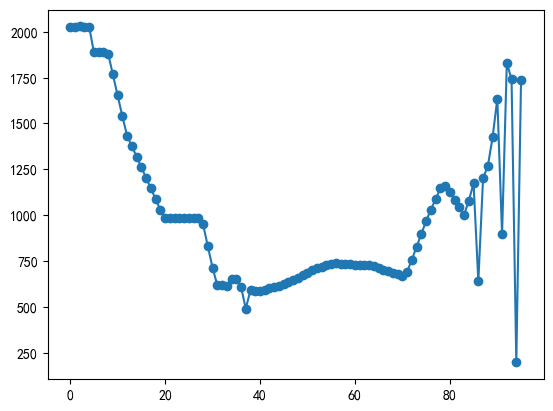

In [28]:
plt.plot(P_data_val+P_cooling_val,marker='o')

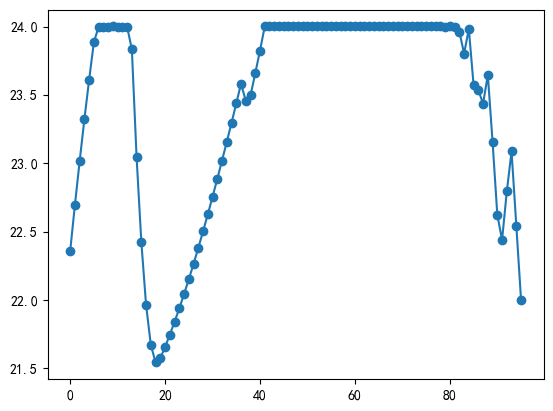

In [24]:
temperature=np.zeros(T)
for i in range(T):
    temperature[i]=T_cooling[i].X
plt.plot(temperature,marker='o')
#plt.show()

In [29]:
for var,val in zip(A_BW_t.values(),A_BW_val):
    var.Start=val
for var,val in zip(A_IW_t.values(),A_IW_val):
    var.Start=val
for var,val in zip(A_R_t.values(),A_R_val):
    var.Start=val
for var,val in zip(P_cooling_t.values(),P_cooling_val):
    var.Start=val
for var,val in zip(T_cooling.values(),T_cooling_val):
    var.Start=val
for var,val in zip(L_BW_t.values(),L_BW_val):
    var.Start=val
for var,val in zip(L_IW_t.values(),L_IW_val):
    var.Start=val
for var,val in zip(P_data_t.values(),P_data_val):
    var.Start=val
    
for i in range(3):
    for var,val in zip(gen_Ps[i].values(),gen_Ps_val[i]):
        var.Start=val
    for var,val in zip(gen_Qs[i].values(),gen_Qs_val[i]):
        var.Start=val
for i in range(32):
    for var,val in zip(bus_square_voltages[i].values(),bus_square_voltages_val[i]):
        var.Start=val
    for var,val in zip(branch_P[i].values(),branch_P_val[i]):
        var.Start=val
    for var,val in zip(branch_Q[i].values(),branch_Q_val[i]):
        var.Start=val
    for var,val in zip(branch_square_currents[i].values(),branch_square_currents_val[i]):
        var.Start=val

In [30]:
model2.params.FeasibilityTol = 0.002 
model2.setObjective(0.4*(gp.quicksum(gen_Ps[0][i]  for i in range(T)))+0.5*(gp.quicksum(gen_Ps[1][i]  for i in range(T)))
                    +0.6*(gp.quicksum(gen_Ps[2][i] for i in range(T)))
                    +gp.quicksum(electricity_price[i]*branch_P[0][i] for i in range(T))+gp.quicksum(electricity_price[i]*branch_Q[0][i] for i in range(T)),GRB.MINIMIZE)
model2.optimize()

Set parameter FeasibilityTol to value 0.002
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 11605 rows, 13632 columns and 44832 nonzeros
Model fingerprint: 0xbbb12d1e
Model has 3072 quadratic constraints
Variable types: 13344 continuous, 288 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+06]
  QMatrix range    [4e+00, 4e+00]
  QLMatrix range   [6e+02, 6e+02]
  Objective range  [2e-01, 6e-01]
  Bounds range     [1e+01, 4e+04]
  RHS range        [6e-01, 2e+08]

User MIP start did not produce a new incumbent solution
MIP start from previous solve did not produce a new incumbent solution

Presolve removed 1522 rows and 861 columns
Presolve time: 0.73s
Presolved: 10083 rows, 12771 columns, 39856 nonzeros
Presolved model has 3072 quadratic constraint(s)
Variable types: 12483 c

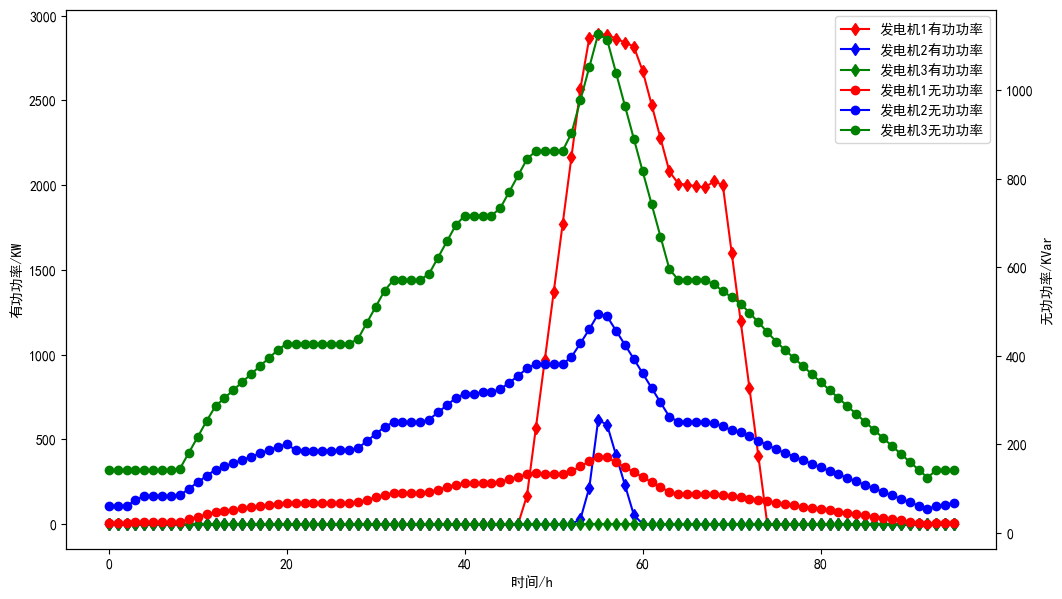

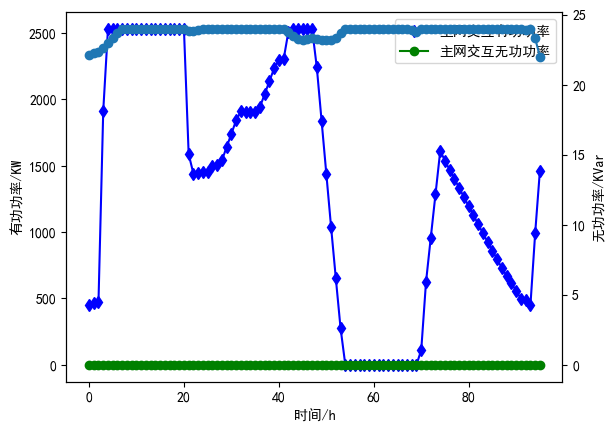

In [20]:
gen_active_power_1,gen_active_power_2,gen_active_power_3,gen_reactive_power_1,gen_reactive_power_2,gen_reactive_power_3=[],[],[],[],[],[]
for i in range(96):
    gen_active_power_1.append(gen_Ps[0][i].X)
    gen_active_power_2.append(gen_Ps[1][i].X)
    gen_active_power_3.append(gen_Ps[2][i].X)
    gen_reactive_power_1.append(gen_Qs[0][i].X)
    gen_reactive_power_2.append(gen_Qs[1][i].X)
    gen_reactive_power_3.append(gen_Qs[2][i].X)
utility_grid_active_power_exchange,utility_grid_reactive_power_exchange=[],[]
for i in range(96):
    utility_grid_active_power_exchange.append(branch_P[0][i].X)
    utility_grid_reactive_power_exchange.append(branch_Q[0][i].X)

plt.rcParams['font.sans-serif'] = ['SimHei'] 
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

#绘制三个发电机的出力曲线
fig1, ax1 = plt.subplots(figsize=(12,7))
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(gen_active_power_1,marker='d',color='r',label='发电机1有功功率')
ax2.plot(gen_reactive_power_1,marker='o',color='r',label='发电机1无功功率')
ax1.plot(gen_active_power_2,marker='d',color='b',label='发电机2有功功率')
ax2.plot(gen_reactive_power_2,marker='o',color='b',label='发电机2无功功率')
ax1.plot(gen_active_power_3,marker='d',color='g',label='发电机3有功功率')
ax2.plot(gen_reactive_power_3,marker='o',color='g',label='发电机3无功功率')

lines1,labels1=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='best')
#plt.show()

#绘制主网交互功率曲线
fig1, ax1 = plt.subplots()
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(utility_grid_active_power_exchange,marker='d',color='b',label='主网交互有功功率')
ax2.plot(utility_grid_reactive_power_exchange,marker='o',color='g',label='主网交互无功功率')

lines1,labels1=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='best')
#plt.show()

temperature=np.zeros(T)
for i in range(T):
    temperature[i]=T_cooling[i].X
plt.plot(temperature,marker='o')
#plt.show()


In [18]:
model2.write('model2.lp')